# Install Packages

In [ ]:
!pip install git+https://github.com/copick/copick-utils.git matplotlib tqdm copick 
!pip install "monai-weekly[mlflow]"

In [2]:
!pip -q install zarr

# copick setup

In [ ]:
# Import necessary modules
import os
import shutil

# Define the configuration for the copick project
config_blob = """{
    "name": "czii_cryoet_mlchallenge_2024",
    "description": "2024 CZII CryoET ML Challenge training data.",
    "version": "1.0.0",

    "pickable_objects": [
        {
            "name": "apo-ferritin",
            "is_particle": true,
            "pdb_id": "4V1W",
            "label": 1,
            "color": [  0, 117, 220, 128],
            "radius": 60,
            "map_threshold": 0.0418
        },
        {
            "name": "beta-galactosidase",
            "is_particle": true,
            "pdb_id": "6X1Q",
            "label": 2,
            "color": [ 76,   0,  92, 128],
            "radius": 90,
            "map_threshold": 0.0578
        },
        {
            "name": "ribosome",
            "is_particle": true,
            "pdb_id": "6EK0",
            "label": 3,
            "color": [  0,  92,  49, 128],
            "radius": 150,
            "map_threshold": 0.0374
        },
        {
            "name": "thyroglobulin",
            "is_particle": true,
            "pdb_id": "6SCJ",
            "label": 4,
            "color": [ 43, 206,  72, 128],
            "radius": 130,
            "map_threshold": 0.0278
        },
        {
            "name": "virus-like-particle",
            "is_particle": true,
            "label": 5,
            "color": [255, 204, 153, 128],
            "radius": 135,
            "map_threshold": 0.201
        }
    ],

    "overlay_root": "/kaggle/working/overlay",

    "overlay_fs_args": {
        "auto_mkdir": true
    },

    "static_root": "/kaggle/input/czii-cryo-et-object-identification/train/static"
}"""

# Define paths for the copick configuration file and the output overlay directory
copick_config_path = "/kaggle/working/copick.config"
output_overlay = "/kaggle/working/overlay"

# Write the configuration to a file
with open(copick_config_path, "w") as f:
    f.write(config_blob)

# Define source and destination directories for the overlay update
source_dir = '/kaggle/input/czii-cryo-et-object-identification/train/overlay'
destination_dir = '/kaggle/working/overlay'

# Walk through the source directory
for root, dirs, files in os.walk(source_dir):
    # Create corresponding subdirectories in the destination
    relative_path = os.path.relpath(root, source_dir)
    target_dir = os.path.join(destination_dir, relative_path)
    os.makedirs(target_dir, exist_ok=True)
    
    # Copy and rename each file
    for file in files:
        # Rename files that do not start with "curation_0_"
        if file.startswith("curation_0_"):
            new_filename = file
        else:
            new_filename = f"curation_0_{file}"
        
        # Define full paths for the source and destination files
        source_file = os.path.join(root, file)
        destination_file = os.path.join(target_dir, new_filename)
        
        # Copy the file with the new name
        shutil.copy2(source_file, destination_file)
        print(f"Copied {source_file} to {destination_file}")

Copied /kaggle/input/czii-cryo-et-object-identification/train/overlay/ExperimentRuns/TS_86_3/Picks/beta-amylase.json to /kaggle/working/overlay/ExperimentRuns/TS_86_3/Picks/curation_0_beta-amylase.json
Copied /kaggle/input/czii-cryo-et-object-identification/train/overlay/ExperimentRuns/TS_86_3/Picks/beta-galactosidase.json to /kaggle/working/overlay/ExperimentRuns/TS_86_3/Picks/curation_0_beta-galactosidase.json
Copied /kaggle/input/czii-cryo-et-object-identification/train/overlay/ExperimentRuns/TS_86_3/Picks/apo-ferritin.json to /kaggle/working/overlay/ExperimentRuns/TS_86_3/Picks/curation_0_apo-ferritin.json
Copied /kaggle/input/czii-cryo-et-object-identification/train/overlay/ExperimentRuns/TS_86_3/Picks/virus-like-particle.json to /kaggle/working/overlay/ExperimentRuns/TS_86_3/Picks/curation_0_virus-like-particle.json
Copied /kaggle/input/czii-cryo-et-object-identification/train/overlay/ExperimentRuns/TS_86_3/Picks/ribosome.json to /kaggle/working/overlay/ExperimentRuns/TS_86_3/Pic

# Import Libraries

In [64]:
import os
import numpy as np
from pathlib import Path
import torch
import torchinfo
import zarr, copick
from tqdm import tqdm
from monai.data import DataLoader, Dataset, CacheDataset, decollate_batch
from monai.transforms import (
    Compose, 
    EnsureChannelFirstd, 
    Orientationd,  
    AsDiscrete,  
    RandFlipd, 
    RandRotate90d, 
    NormalizeIntensityd,
    RandCropByLabelClassesd,
)
from monai.networks.nets import UNet
from monai.losses import DiceLoss, FocalLoss, TverskyLoss
from monai.metrics import DiceMetric, ConfusionMatrixMetric
import mlflow
import mlflow.pytorch

# Prepare the dataset
## 1. Get copick root

In [65]:
root = copick.from_file(copick_config_path)

copick_user_name = "copickUtils"
copick_segmentation_name = "paintedPicks"
voxel_size = 10
tomo_type = "denoised"

## 2. Generate multi-class segmentation masks from picks

In [ ]:
from copick_utils.segmentation import segmentation_from_picks
import copick_utils.writers.write as write
from collections import defaultdict

generate_masks = True

if generate_masks:
    # Create a dictionary to store target objects with their labels and radii
    target_objects = defaultdict(dict)
    for object in root.pickable_objects:
        if object.is_particle:
            target_objects[object.name]['label'] = object.label
            target_objects[object.name]['radius'] = object.radius

    # Iterate through each run in the root object
    for run in tqdm(root.runs):
        # Get the tomogram with the specified voxel size and type
        tomo = run.get_voxel_spacing(10)
        tomo = tomo.get_tomogram(tomo_type).numpy()
        
        # Initialize an empty target array with the same shape as the tomogram
        target = np.zeros(tomo.shape, dtype=np.uint8)
        
        # Iterate through each pickable object
        for pickable_object in root.pickable_objects:
            # Get the picks for the current object
            pick = run.get_picks(object_name=pickable_object.name, user_id="curation")
            
            # If there are picks, generate the segmentation mask
            if len(pick):  
                target = segmentation_from_picks.from_picks(
                    pick[0], 
                    target, 
                    target_objects[pickable_object.name]['radius'] * 0.8,
                    target_objects[pickable_object.name]['label']
                )
        
        # Write the generated segmentation mask to the run
        write.segmentation(run, target, copick_user_name, name=copick_segmentation_name)

100%|██████████| 7/7 [00:06<00:00,  1.03it/s]


## 3. Get tomograms and their segmentaion masks (from picks) arrays

In [ ]:
data_dicts = []

# Iterate through each run in the root object
for run in tqdm(root.runs):
    # Get the tomogram with the specified voxel size and type
    tomogram = run.get_voxel_spacing(voxel_size).get_tomogram(tomo_type).numpy()
    
    # Get the segmentation mask for the tomogram
    segmentation = run.get_segmentations(
        name=copick_segmentation_name, 
        user_id=copick_user_name, 
        voxel_size=voxel_size, 
        is_multilabel=True
    )[0].numpy()
    
    # Append the tomogram and its corresponding segmentation mask to the data_dicts list
    data_dicts.append({"image": tomogram, "label": segmentation})
    
# Print the unique labels in the first segmentation mask
print(np.unique(data_dicts[0]['label']))

100%|██████████| 7/7 [00:05<00:00,  1.24it/s]


[0 1 2 3 4 5]


## 4. Visualize the tomogram and painted segmentation from ground-truth picks

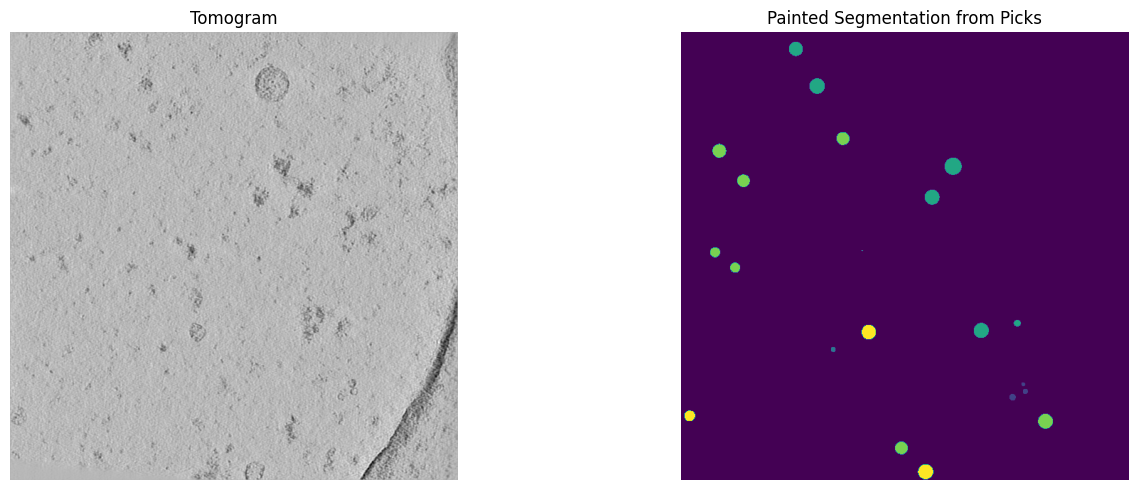

In [68]:
import matplotlib.pyplot as plt

# Plot the images
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.title('Tomogram')
plt.imshow(data_dicts[0]['image'][100],cmap='gray')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title('Painted Segmentation from Picks')
plt.imshow(data_dicts[0]['label'][100], cmap='viridis')
plt.axis('off')

plt.tight_layout()
plt.show()


## 5. Prepare dataloaders

In [ ]:
my_num_samples = 16
# batch sizes
train_batch_size = 1
val_batch_size = 1
test_batch_size = 1

# Split the data into training, validation, and test sets
train_files, val_files, test_file = data_dicts[:4], data_dicts[4:5], data_dicts[5:]
print(f"Number of training samples: {len(train_files)}")
print(f"Number of validation samples: {len(val_files)}")

# Non-random transforms to be cached
non_random_transforms = Compose([
    EnsureChannelFirstd(keys=["image", "label"], channel_dim="no_channel"),
    NormalizeIntensityd(keys="image"),
    Orientationd(keys=["image", "label"], axcodes="RAS")
])

# Random transforms to be applied during training
random_transforms = Compose([
    RandCropByLabelClassesd(
        keys=["image", "label"],
        label_key="label",
        spatial_size=[96, 96, 96],
        num_classes=6,
        num_samples=my_num_samples
    ),
    RandRotate90d(keys=["image", "label"], prob=0.5, spatial_axes=[0, 2]),
    RandFlipd(keys=["image", "label"], prob=0.5, spatial_axis=0),    
])

# Create the cached dataset with non-random transforms
train_ds = CacheDataset(data=train_files, transform=non_random_transforms, cache_rate=1.0)

# Wrap the cached dataset to apply random transforms during iteration
train_ds = Dataset(data=train_ds, transform=random_transforms)

# Create DataLoader for training data
train_loader = DataLoader(
    train_ds,
    batch_size=train_batch_size,
    shuffle=True,
    num_workers=4,
    pin_memory=torch.cuda.is_available()
)

# Validation transforms
val_transforms = Compose([
    EnsureChannelFirstd(keys=["image", "label"], channel_dim="no_channel"),
    NormalizeIntensityd(keys="image"),
    RandCropByLabelClassesd(
        keys=["image", "label"],
        label_key="label",
        spatial_size=[96, 96, 96],
        num_classes=6,
        num_samples=my_num_samples, 
    ),
])

# Create validation dataset
val_ds = CacheDataset(data=val_files, transform=val_transforms, cache_rate=1.0)

# Create validation DataLoader
val_loader = DataLoader(
    val_ds,
    batch_size=val_batch_size,
    num_workers=4,
    pin_memory=torch.cuda.is_available(),
    shuffle=False,  # Ensure the data order remains consistent
)

# Test transforms (non-random)
from monai.transforms import ResizeWithPadOrCropd

test_transforms = Compose([
    EnsureChannelFirstd(keys=["image", "label"], channel_dim="no_channel"),
    NormalizeIntensityd(keys="image"),
    Orientationd(keys=["image", "label"], axcodes="RAS"),
    ResizeWithPadOrCropd(keys=["image", "label"], spatial_size=[96, 96, 96])  # Ensure consistent size
])

# Cache non-random transforms for test
test_ds = CacheDataset(data=test_file, transform=test_transforms, cache_rate=1.0)

# Create DataLoader for test data
test_loader = DataLoader(
    test_ds,
    batch_size=test_batch_size,
    shuffle=False,  # Consistent order for testing
    num_workers=4,
    pin_memory=torch.cuda.is_available()
)


Number of training samples: 4
Number of validation samples: 1


Loading dataset: 100%|██████████| 2/2 [00:01<00:00,  1.36it/s]


## Model setup

In [ ]:
# Set the device to GPU if available, otherwise use CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

# Create a 3D UNet model
model = UNet(
    spatial_dims=3,  # 3D input
    in_channels=1,  # Single channel input (e.g., grayscale image)
    out_channels=len(root.pickable_objects) + 1,  # Number of output classes + background
    channels=(48, 64, 80, 80),  # Number of channels in each layer
    strides=(2, 2, 1),  # Strides for each layer
    num_res_units=2,  # Number of residual units
).to(device)  # Move the model to the specified device

# Alternative UNet model configuration (commented out)
# model = UNet(
#     spatial_dims=3,
#     in_channels=1,
#     out_channels=len(root.pickable_objects) + 1,
#     channels=(32, 64, 128, 256, 512),
#     strides=(2, 2, 2, 2),
#     num_res_units=2,
# ).to(device)

# Set the learning rate
lr = 5e-3

# Create an Adam optimizer
optimizer = torch.optim.Adam(model.parameters(), lr)

# Define the loss function (TverskyLoss for multiclass segmentation)
# loss_function = DiceLoss(include_background=True, to_onehot_y=True, softmax=True)  # Alternative loss function
loss_function = TverskyLoss(include_background=True, to_onehot_y=True, softmax=True)  # softmax=True for multiclass

# Define the Dice metric for evaluation
dice_metric = DiceMetric(include_background=False, reduction="mean", ignore_empty=True)  # must use onehot for multiclass

# Define the recall metric for evaluation
recall_metric = ConfusionMatrixMetric(include_background=False, metric_name="recall", reduction="None")

cuda


In [129]:
import matplotlib.pyplot as plt

# Plot the loss curve
def plot_loss_curve(epoch_loss_values):
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, len(epoch_loss_values) + 1), epoch_loss_values, marker='o')
    plt.title("Training Loss Over Epochs")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.grid(True)
    plt.show()


In [ ]:
# Define post-processing for predictions and labels
post_pred = AsDiscrete(argmax=True, to_onehot=len(root.pickable_objects)+1)
post_label = AsDiscrete(to_onehot=len(root.pickable_objects)+1)

def train(train_loader, model, loss_function, metrics_function, optimizer, max_epochs=25):
    val_interval = 2  # Interval for validation
    best_metric = -1  # Initialize the best metric
    best_metric_epoch = -1  # Initialize the epoch with the best metric
    epoch_loss_values = []  # List to store loss values for each epoch
    metric_values = []  # List to store metric values for each epoch

    for epoch in range(max_epochs):
        print("-" * 10)
        print(f"epoch {epoch + 1}/{max_epochs}")
        model.train()  # Set the model to training mode
        epoch_loss = 0  # Initialize the epoch loss
        step = 0  # Initialize the step counter

        for batch_data in train_loader:
            step += 1
            inputs = batch_data["image"].to(device)  # Move inputs to the device
            labels = batch_data["label"].to(device)  # Move labels to the device
            optimizer.zero_grad()  # Zero the gradients
            outputs = model(inputs)  # Forward pass
            loss = loss_function(outputs, labels)  # Compute the loss
            loss.backward()  # Backward pass
            optimizer.step()  # Update the weights
            epoch_loss += loss.item()  # Accumulate the loss
            print(f"batch {step}/{len(train_ds) // train_loader.batch_size}, train_loss: {loss.item():.4f}")

        epoch_loss /= step  # Compute the average loss for the epoch
        epoch_loss_values.append(epoch_loss)  # Append the epoch loss to the list
        print(f"epoch {epoch + 1} average loss: {epoch_loss:.4f}")
        mlflow.log_metric("train_loss", epoch_loss, step=epoch+1)  # Log the training loss to MLflow

        if (epoch + 1) % val_interval == 0:
            model.eval()  # Set the model to evaluation mode
            with torch.no_grad():  # Disable gradient computation
                for val_data in val_loader:
                    val_inputs = val_data["image"].to(device)  # Move validation inputs to the device
                    val_labels = val_data["label"].to(device)  # Move validation labels to the device
                    val_outputs = model(val_inputs)  # Forward pass
                    metric_val_outputs = [post_pred(i) for i in decollate_batch(val_outputs)]  # Post-process predictions
                    metric_val_labels = [post_label(i) for i in decollate_batch(val_labels)]  # Post-process labels
                    
                    # Compute metric for current iteration
                    metrics_function(y_pred=metric_val_outputs, y=metric_val_labels)

                metrics = metrics_function.aggregate(reduction="mean_batch")  # Aggregate metrics across the batch
                metric_per_class = ["{:.4g}".format(x) for x in metrics]  # Format metrics for each class
                metric = torch.mean(metrics).numpy(force=True)  # Compute the overall mean metric
                mlflow.log_metric("validation metric", metric, step=epoch+1)  # Log the validation metric to MLflow
                for i, m in enumerate(metrics):
                    mlflow.log_metric(f"validation metric class {i+1}", m, step=epoch+1)  # Log metrics for each class to MLflow
                metrics_function.reset()  # Reset metrics for the next validation interval

                metric_values.append(metric)  # Append the metric to the list
                if metric > best_metric:
                    best_metric = metric  # Update the best metric
                    best_metric_epoch = epoch + 1  # Update the epoch with the best metric
                    torch.save(model.state_dict(), os.path.join('./', "best_metric_model.pth"))  # Save the best model
                    
                    print("saved new best metric model")
                print(
                    f"current epoch: {epoch + 1} current mean recall per class: {', '.join(metric_per_class)}"
                    f"\nbest mean recall: {best_metric:.4f} "
                    f"at epoch: {best_metric_epoch}"
                )
    plot_loss_curve(epoch_loss_values)  # Plot the loss curve

## Training and tracking

In [131]:
import warnings
warnings.filterwarnings("ignore")

----------
epoch 1/100
batch 1/4, train_loss: 0.9465
batch 2/4, train_loss: 0.9296
batch 3/4, train_loss: 0.9069
batch 4/4, train_loss: 0.8827
epoch 1 average loss: 0.9165
----------
epoch 2/100
batch 1/4, train_loss: 0.8738
batch 2/4, train_loss: 0.8549
batch 3/4, train_loss: 0.8400
batch 4/4, train_loss: 0.8362
epoch 2 average loss: 0.8513
saved new best metric model
current epoch: 2 current mean recall per class: 0.0001459, 0.0006479, 0.2961, 0.00475, 0.01173
best mean recall: 0.0627 at epoch: 2
----------
epoch 3/100
batch 1/4, train_loss: 0.8227
batch 2/4, train_loss: 0.8211
batch 3/4, train_loss: 0.8161
batch 4/4, train_loss: 0.8109
epoch 3 average loss: 0.8177
----------
epoch 4/100
batch 1/4, train_loss: 0.8105
batch 2/4, train_loss: 0.8078
batch 3/4, train_loss: 0.7857
batch 4/4, train_loss: 0.7925
epoch 4 average loss: 0.7991
saved new best metric model
current epoch: 4 current mean recall per class: 0.01184, 0.0009982, 0.3058, 0.09979, 0.04912
best mean recall: 0.0935 at epo

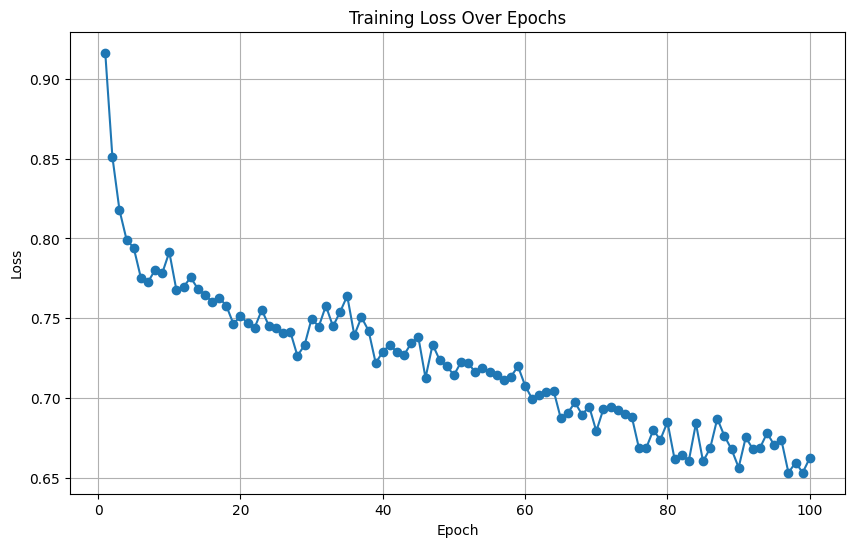

2024/12/19 01:28:40 WARNING mlflow.utils.environment: Encountered an unexpected error while inferring pip requirements (model URI: /tmp/tmptdqvtj6z/model/data, flavor: pytorch). Fall back to return ['torch==2.4.0', 'cloudpickle==3.0.0']. Set logging level to DEBUG to see the full traceback. 
2024/12/19 01:28:40 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


In [132]:
from torchinfo import summary

mlflow.end_run()
mlflow.set_experiment('training 3D U-Net model for the cryoET ML Challenge')
epochs = 100
with mlflow.start_run():
    params = {
        "epochs": epochs,
        "learning_rate": lr,
        "loss_function": loss_function.__class__.__name__,
        "metric_function": recall_metric.__class__.__name__,
        "optimizer": "Adam",
    }
    # Log training parameters.
    mlflow.log_params(params)

    # Log model summary.
    with open("model_summary.txt", "w") as f:
        f.write(str(summary(model)))
    mlflow.log_artifact("model_summary.txt")

    train(train_loader, model, loss_function, dice_metric, optimizer, max_epochs=epochs)

    # Save the trained model to MLflow.
    mlflow.pytorch.log_model(model, "model")

In [134]:
# Define post-processing for predictions and labels
post_pred = AsDiscrete(argmax=True, to_onehot=7)  # 7 classes (1-7)
post_label = AsDiscrete(to_onehot=7)


def test(test_loader, model, metrics_function):
    print("-" * 10)
    print("Starting testing...")
    model.eval()

    with torch.no_grad():
        for test_data in test_loader:
            test_inputs = test_data["image"].to(device)
            test_labels = test_data["label"].to(device)

            # Get model predictions
            test_outputs = model(test_inputs)
            metric_test_outputs = [post_pred(i) for i in decollate_batch(test_outputs)]
            metric_test_labels = [post_label(i) for i in test_labels]
            
            # Compute metrics for the current test batch
            metrics_function(y_pred=metric_test_outputs, y=metric_test_labels)
        
        # Aggregate metrics across the entire test set
        metric_per_class = metrics_function.aggregate(reduction="mean_batch")
        
        mean_metric = torch.mean(metric_per_class[0][:-1]).item()  # Compute the overall mean metric

        print(f"Test mean recall per class: {', '.join([f'{x:.4f}' for x in metric_per_class[0].tolist()[:-1]])}")

        print(f"Test mean recall overall: {mean_metric:.4f}")

        # Reset metrics for future use
        metrics_function.reset()

    return mean_metric, metric_per_class


        

# Load the best model
# model.load_state_dict(torch.load(os.path.join('./', "best_metric_model.pth")))

# Test the model and log results
mean_metric, metric_per_class = test(test_loader, model, recall_metric)


----------
Starting testing...
Test mean recall per class: 0.6985, 0.3634, 0.8049, 0.4935, 0.2630
Test mean recall overall: 0.5246
